# How to actually pre-process Datasets?

In [1]:
!pip install -q --upgrade pip

In [2]:
!pip install -q scipy scikit-learn polars

In [22]:
import os
from collections import Counter

import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import polars as pl
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer

In [4]:
DATASET_LIST = !cat ../datasets/datasets.txt
ARFF_PATH = '../datasets/arff/'

## ARFF datasets

In [6]:
arff_files = {dataset: os.path.join(ARFF_PATH, dataset + ".arff") for dataset in DATASET_LIST}

### Exemplo Teste

Analisando o dataset `ozone-eighthr`, que apresentou resultados praticamente aletórios no meu experimento

In [7]:
chosen_dataset = "ozone-eighthr"

In [8]:
data, metadata = arff.loadarff(arff_files[chosen_dataset])
data_df = pd.DataFrame(data)

O dataset possui apenas valores numéricos, o que torna desnecessária a codificação de atributos nominais.
Dessa forma se ele apresentar um desempenho ruim, há um indicativo de que o problema não está na codificação, mas em outra parte do pre-processamento.

In [9]:
pd.value_counts(metadata.types())

numeric    72
nominal     1
Name: count, dtype: int64

Testando desempenho do SVM padrão do sklearn no dataset escolhido

In [10]:
X, y = data_df.iloc[:, :-1], LabelEncoder().fit_transform(data_df.iloc[:, -1])
X.shape, y.shape

((2534, 72), (2534,))

In [11]:
Counter(y)

Counter({0: 2374, 1: 160})

In [12]:
clf = SVC()
scaler = StandardScaler()
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [13]:
X = scaler.fit_transform(X)

In [14]:
def test_passive(clf, X, y):
    score_list = []

    for _ in range(5):
        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            clf.fit(X_train, y_train)
    
            y_pred = clf.predict(X_test)
    
            kappa = cohen_kappa_score(y_pred, y_test)
            f1 = f1_score(y_test, y_pred)
            score_list.append(kappa)
        
    score_list = np.array(score_list)
    return score_list

O pré-processamento dos dados levou a um desempenho melhor, mesmo que muito pequeno:

In [15]:
score_list = test_passive(clf, X, y)
print(f'{score_list.mean()} +/- {score_list.std()}')

0.017912922209118637 +/- 0.030486205980623952


### Comparando com resultados do Davi

In [16]:
# !tar -xzf results_davi.tgz

In [88]:
from io import StringIO

def get_results_davi(dataset):
    
    search_string = f"'{dataset}.*SVM'"

    lines = !grep -E $search_string neurocomputing2019-kappa-5x5-fold-75datasets-15strats-5classifs.csv
    
    result = pd.read_csv(StringIO( '\n'.join(lines)), names=["dataset", "method", "learner", "fold", "run", "query", "kappa"])

    return result
   

In [89]:
df = get_results_davi(chosen_dataset)
df.head()

,dataset,method,learner,fold,run,query,kappa
0,ozone-eighthr,SG,SVM,0,0,0,-0.031033
1,ozone-eighthr,SG,SVM,0,0,1,-0.067304
2,ozone-eighthr,SG,SVM,0,0,2,0.000000
3,ozone-eighthr,SG,SVM,0,0,3,0.000000
4,ozone-eighthr,SG,SVM,0,0,4,0.000000


In [19]:
print(list(df.method.unique()))

[' SG', ' OER', ' HTUmah', ' HTUeuc', ' Mar', ' TUeuc', ' Rnd', ' TUmah', ' ATUmah', ' TUman', ' HTUman', ' ERE', ' ATUman', ' HS', ' ATUeuc']


In [141]:
def plot_curve(df, method, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title("Active Learning (Santos 2019)")
    ax.set_ylim(-1, 1)
    ax.grid(True)
    for group, data in df.groupby(["method", 'fold', 'run']):
        if group[0] == method:
            ax.plot(data['kappa'].values, linestyle=":", color='steelblue', alpha=0.5)
           

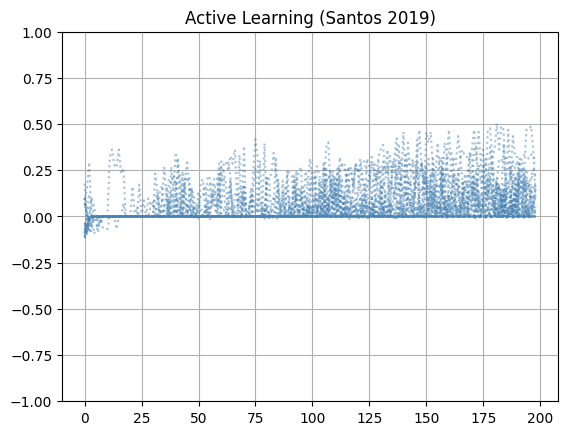

In [198]:
plot_curve(df, ' Rnd')

### Conclusões

Visto que o dataset é muito desbalanceado, existe a possibilidade de o uso do conjunto de dados completo tenha um desempenho pior do que o active learning em si. O que explicaria o desempenho ruim do aprendizado passivo.
Entretanto, **está hipótese ainda precisa ser testada** por meio da aplicação de active learning nas minhas configurações e com o pré-processamento dos dados.

Além disso, é necessário reproduzir em exeperimento em um conjunto de dados, onde o desempenho final do AL seja mais próximo do desempnho do aprendizado passivo

## Segundo Exemplo de Teste

In [191]:
chosen_dataset = 'climate-simulation-craches'

In [192]:
data, metadata = arff.loadarff(arff_files[chosen_dataset])

### Resultados do Davi

In [219]:
results_davi = get_results_davi(chosen_dataset)
results_davi.head()

,dataset,method,learner,fold,run,query,kappa
0,climate-simulation-craches,SG,SVM,0,0,0,0.022472
1,climate-simulation-craches,SG,SVM,0,0,1,-0.023952
2,climate-simulation-craches,SG,SVM,0,0,2,-0.016949
3,climate-simulation-craches,SG,SVM,0,0,3,-0.034965
4,climate-simulation-craches,SG,SVM,0,0,4,0.007782


Com base no plot abaixo, é esperado que o SVM seja capaz de atigir um kappa próximo de 0.75 usando todos os dados

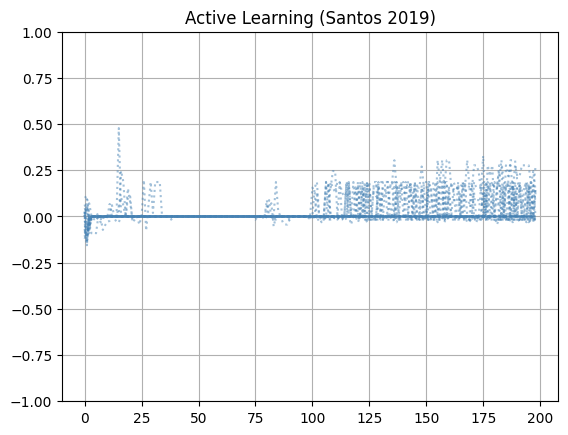

In [279]:
plot_curve(results_davi, ' Mar')

### Testando Aprendizado Passivo

In [201]:
data_df = pd.DataFrame(data)
data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,Class
0,1.0,1.0,502.0,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,b'1'
1,1.0,2.0,249.0,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,b'2'
2,1.0,3.0,202.0,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,b'2'
3,1.0,4.0,56.0,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,b'2'
4,1.0,5.0,278.0,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,b'2'


In [218]:
metadata

Dataset: climate-simulation-craches
	V1's type is numeric
	V2's type is numeric
	V3's type is numeric
	V4's type is numeric
	V5's type is numeric
	V6's type is numeric
	V7's type is numeric
	V8's type is numeric
	V9's type is numeric
	V10's type is numeric
	V11's type is numeric
	V12's type is numeric
	V13's type is numeric
	V14's type is numeric
	V15's type is numeric
	V16's type is numeric
	V17's type is numeric
	V18's type is numeric
	V19's type is numeric
	V20's type is numeric
	Class's type is nominal, range is ('1', '2')

In [230]:
X, y = data_df.iloc[:, :-1], data_df.iloc[:, -1]
X.shape, y.shape

((540, 20), (540,))

In [231]:
y.value_counts()

Class
b'2'    494
b'1'     46
Name: count, dtype: int64

Preprocessamento:

In [232]:
nominal_mask = [x == 'nominal' for x in metadata.types()][:-1]
numeric_mask = [not x for x in nominal_mask]

one_hot_encoder = OneHotEncoder(sparse_output=False)
standard_scaler = StandardScaler()

column_transformers = [
    ('one-hot-encoder' , one_hot_encoder, nominal_mask),
    ('standard-scaler', standard_scaler, numeric_mask)
]
preprocessor = ColumnTransformer(column_transformers, remainder='passthrough')

In [233]:
X_new = preprocessor.fit_transform(X)
y_new = LabelEncoder().fit_transform(y)
X_new.shape, y_new.shape

((540, 20), (540,))

In [234]:
score_list = test_passive(SVC(), X_new, y_new)
print(f'{score_list.mean()} +/- {score_list.std()}')

0.0 +/- 0.0


### Testando AL dos experimentos

In [85]:
rand_df = pd.read_csv('random_sampling_5_horse-colic-surgical.csv', index_col=0)
margin_df = pd.read_csv('margin_sampling_5_horse-colic-surgical.csv', index_col=0)

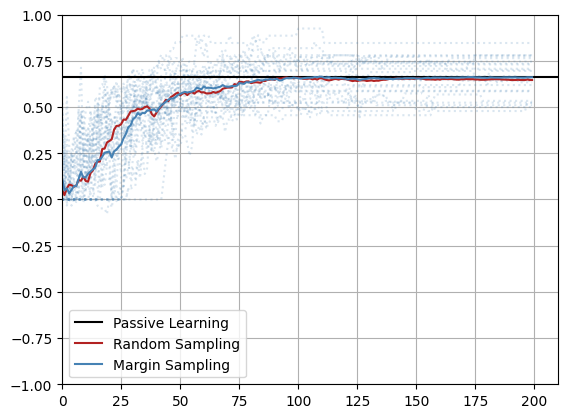

In [86]:
fig, ax = plt.subplots()

for k, c in margin_df.items():
    ax.plot(c, color="steelblue", linestyle=":", alpha=0.2)

ax.axhline(score_list.mean(), color="black", label="Passive Learning")
ax.plot(rand_df.mean(axis=1), color="firebrick", label="Random Sampling")
ax.plot(margin_df.mean(axis=1), color="steelblue", label="Margin Sampling")

ax.set_ylim(-1,1)
ax.set_xlim(0,210)
ax.grid(True)
ax.legend()

### Testando Aprendizado Ativo do zero

In [38]:
!pip install -q modAL-python

In [39]:
from modAL.models import ActiveLearner
from sklearn.model_selection import train_test_split
from modAL.uncertainty import margin_sampling

In [274]:
def test_active_learning(X_train, y_train, X_test, y_test, budget=200, query_strategy=margin_sampling):

    safe = False
    while not safe:
        
        # seleciona dados iniciais para serem rotulados 
        l_index = np.zeros(len(y_train),dtype=bool)
        rng = np.random.default_rng()
        initial_label_mask = rng.choice(len(y_train),size=2)
        l_index[initial_label_mask] = True

        # Cria Pool L
        X_l_pool, y_l_pool = X_train[l_index], y_train[l_index]


        if len(np.unique(y_l_pool)) > 1:
            safe = True
            
    print(pd.value_counts(y_l_pool))
    
    # Cria Pool U
    X_u_pool, y_u_pool = X_train[~l_index], y_train[~l_index]

    # Instancia aprendiz ativo
    learner = ActiveLearner(estimator=SVC(probability=True),
                            X_training=X_l_pool,
                            y_training=y_l_pool,
                            query_strategy=query_strategy)

    score_list = []
    
    for x in range(budget):
    
        query_index, _ = learner.query(X_u_pool)

        learner.teach(X_u_pool[query_index], y_u_pool[query_index])

        X_u_pool = np.delete(X_u_pool, query_index, axis=0)
        y_u_pool = np.delete(y_u_pool, query_index)
    
        y_pred = learner.predict(X_test)

        score = cohen_kappa_score(y_pred, y_test)

        score_list.append(score)

    return score_list

In [236]:
def random_sampling(learner, X, n_instances=1):
    rng = np.random.default_rng()
    query_idx = rng.choice(range(len(X)), size=n_instances,
                                 replace=False)

    return query_idx, X[query_idx]
    
random_score = test_active_learning(X_train, y_train, X_test, y_test)

In [275]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

score_lists = []
for _ in range(5):
    for train_index, test_index in cv.split(X_new, y_new):
        print(train_index.shape, test_index.shape)
        score_list = test_active_learning(X_new[train_index], y_new[train_index], 
                                          X_new[test_index], y_new[test_index],
                                          query_strategy=random_sampling)
        score_lists.append(score_list)
    

(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
0    1
1    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1
Name: count, dtype: int64
(432,) (108,)
1    1
0    1


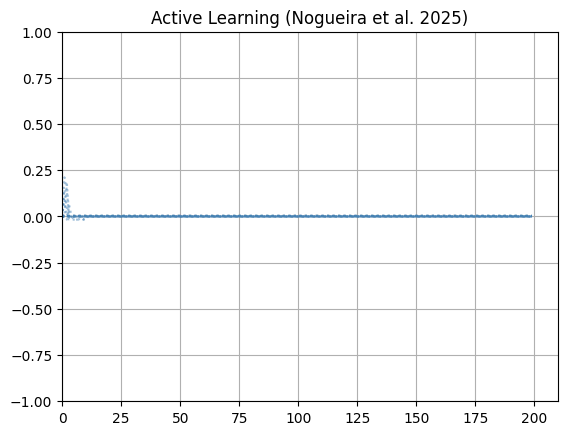

In [276]:
fig, ax = plt.subplots()

for score_list in score_lists:
    ax.plot(score_list, color="steelblue", linestyle=":", alpha=0.5)

# ax.axhline(score_list.mean(), color="black", label="Passive Learning")

ax.set_title("Active Learning (Nogueira et al. 2025)")
ax.set_ylim(-1,1)
ax.set_xlim(0,210)
ax.grid(True)
    

## Comparando Resultados Entre os Trabalhos

In [277]:
def compare_davi(dataset_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(dataset_name)

    results_davi = get_results_davi(dataset_name)
    results_davi = results_davi[results_davi.method == ' Rnd']

    axs[0].grid()
    axs[0].set_ylim(-1,1)
    axs[0].set_title("Santos et al. (2019)")
    
    for k, group in results_davi.groupby(["fold", "run"]):
        axs[0].plot(group.kappa.values, color="steelblue", alpha=0.3, linestyle=":")
        
    axs[0].plot(results_davi.groupby(["query"])['kappa'].mean(), color="steelblue", label="Random Sampling")
        
    
    my_results =  pd.read_csv(f"../experiments/test_reps_results/{dataset_name}.csv", index_col=0)

    for name, col in my_results.items():
        axs[1].plot(col, color="steelblue", alpha=0.3, linestyle=":")
        
    axs[1].plot(my_results.mean(axis=1), color="steelblue", label="Random Sampling")

    axs[1].grid()
    axs[1].set_ylim(-1,1)
    axs[1].set_title("Nogueira et al. (2025)")

    axs[0].legend()
    axs[1].legend()

In [144]:
import ipywidgets as w

In [278]:
w.interact(compare_davi, dataset_name=w.SelectionSlider(options=arff_files.keys()))

interactive(children=(SelectionSlider(description='dataset_name', options=('abalone-3class', 'artificial-chara…

<function __main__.compare_davi(dataset_name)>